In [6]:
# Cell 1: Imports
from google.cloud import bigquery
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

client = bigquery.Client(project="students-group2")

In [7]:
# Cell 2: Load Data
query = """
SELECT userId, movieId, rating
FROM `master-ai-cloud.MoviePlatform.ratings`
"""
df_ratings = client.query(query).to_dataframe()

In [8]:
# Cell 3: Create user-item matrix
user_item_matrix = df_ratings.pivot_table(
    index='userId',
    columns='movieId', 
    values='rating'
).fillna(0)

In [9]:
# Cell 4: Train-test split
# Hold out 20% of ratings for evaluation
def create_train_test_split(df_ratings, test_size=0.2):
    train, test = train_test_split(df_ratings, test_size=test_size, random_state=42)
    
    train_matrix = train.pivot_table(
        index='userId', columns='movieId', values='rating'
    ).fillna(0)
    
    return train_matrix, test

train_matrix, test_df = create_train_test_split(df_ratings)

In [12]:
# Cell 5: SVD Model
def train_svd_model(matrix, k=10):
    """
    Train SVD model with proper normalization
    """
    print(f"Training SVD with k={k} latent factors...")
    
    # Get the raw matrix values
    R = matrix.values  # shape: (n_users, n_movies)
    
    # Calculate user means (only for rated items, not zeros!)
    user_ratings_mean = []
    for i in range(R.shape[0]):
        user_row = R[i, :]
        rated_items = user_row[user_row > 0]  # Only consider rated items
        if len(rated_items) > 0:
            user_ratings_mean.append(rated_items.mean())
        else:
            user_ratings_mean.append(3.5)  # default if user has no ratings
    
    user_ratings_mean = np.array(user_ratings_mean)
    
    # Normalize: subtract user mean ONLY from rated items
    R_normalized = R.copy()
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i, j] > 0:  # Only normalize rated items
                R_normalized[i, j] = R[i, j] - user_ratings_mean[i]
            # Leave zeros as zeros (unrated items)
    
    print(f"Matrix shape: {R_normalized.shape}")
    print(f"User means range: {user_ratings_mean.min():.2f} to {user_ratings_mean.max():.2f}")
    
    # SVD decomposition
    U, sigma, Vt = svds(R_normalized, k=k)
    
    print(f"✓ U shape: {U.shape}")
    print(f"✓ Sigma shape: {sigma.shape}")
    print(f"✓ Vt shape: {Vt.shape}")
    
    # Convert sigma to diagonal matrix
    sigma_diag = np.diag(sigma)
    
    # Quick sanity check
    sample_pred = (U[0] @ sigma_diag @ Vt[:, 0]) + user_ratings_mean[0]
    print(f"Sample prediction: {sample_pred:.2f} (should be 0.5-5.0)")
    
    return U, sigma_diag, Vt, user_ratings_mean

# Train the model
U, sigma, Vt, user_means = train_svd_model(train_matrix, k=10)

Training SVD with k=10 latent factors...
Matrix shape: (668, 9565)
User means range: 1.92 to 5.00
✓ U shape: (668, 10)
✓ Sigma shape: (10,)
✓ Vt shape: (10, 9565)
Sample prediction: 3.70 (should be 0.5-5.0)


In [14]:
# Cell 7: Recommendation function
def get_svd_recommendations(user_id, predictions_df, user_item_matrix, 
                            df_movies, n_recommendations=10):
    """
    Get top-N recommendations for a user
    """
    # Get user's already rated movies
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].index
    
    # Get predictions for this user
    user_predictions = predictions_df.loc[user_id]
    
    # Exclude already rated movies
    user_predictions = user_predictions.drop(rated_movies)
    
    # Get top N
    top_movies = user_predictions.nlargest(n_recommendations)
    
    # Merge with movie metadata
    recommendations = pd.DataFrame({
        'movieId': top_movies.index,
        'predicted_rating': top_movies.values
    })
    
    recommendations = recommendations.merge(
        df_movies[['movieId', 'title', 'genres']], 
        on='movieId'
    )
    
    return recommendations

In [15]:
# Cell 6: Make predictions
def predict_ratings(U, sigma, Vt, user_means, train_matrix):
    """Reconstruct the full ratings matrix"""
    # Reconstruct normalized ratings
    R_pred_normalized = U @ sigma @ Vt
    
    # Add back user means
    R_pred = R_pred_normalized + user_means.reshape(-1, 1)
    
    # Clip to valid range [0.5, 5.0]
    R_pred = np.clip(R_pred, 0.5, 5.0)
    
    # Create DataFrame
    predictions_df = pd.DataFrame(
        R_pred,
        index=train_matrix.index,
        columns=train_matrix.columns
    )
    
    return predictions_df

predictions = predict_ratings(U, sigma, Vt, user_means, train_matrix)

# Verify
print("Prediction check:")
print(f"Min: {predictions.values.min():.2f}")
print(f"Max: {predictions.values.max():.2f}")
print(f"Mean: {predictions.values.mean():.2f}")
print(f"Should be in range [0.5, 5.0] ✓")

Prediction check:
Min: 0.50
Max: 5.00
Mean: 3.67
Should be in range [0.5, 5.0] ✓


HYPERPARAMETER TUNING: Finding Optimal k

Testing k=10...
Training SVD with k=10 latent factors...
Matrix shape: (668, 9565)
User means range: 1.92 to 5.00
✓ U shape: (668, 10)
✓ Sigma shape: (10,)
✓ Vt shape: (10, 9565)
Sample prediction: 3.70 (should be 0.5-5.0)
  RMSE: 0.9100, MAE: 0.7018

Testing k=20...
Training SVD with k=20 latent factors...
Matrix shape: (668, 9565)
User means range: 1.92 to 5.00
✓ U shape: (668, 20)
✓ Sigma shape: (20,)
✓ Vt shape: (20, 9565)
Sample prediction: 3.59 (should be 0.5-5.0)
  RMSE: 0.9107, MAE: 0.7021

Testing k=30...
Training SVD with k=30 latent factors...
Matrix shape: (668, 9565)
User means range: 1.92 to 5.00
✓ U shape: (668, 30)
✓ Sigma shape: (30,)
✓ Vt shape: (30, 9565)
Sample prediction: 3.61 (should be 0.5-5.0)
  RMSE: 0.9152, MAE: 0.7067

Testing k=40...
Training SVD with k=40 latent factors...
Matrix shape: (668, 9565)
User means range: 1.92 to 5.00
✓ U shape: (668, 40)
✓ Sigma shape: (40,)
✓ Vt shape: (40, 9565)
Sample prediction: 3.44

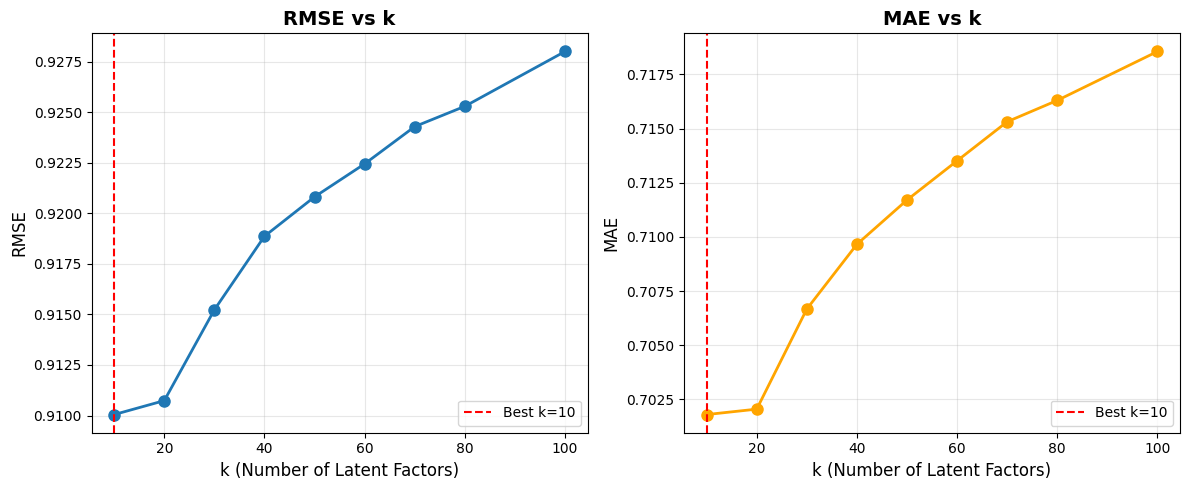


 Saved: hyperparameter_tuning_k.png


In [16]:
# Cell: Hyperparameter Tuning - Find Best k
print("=" * 70)
print("HYPERPARAMETER TUNING: Finding Optimal k")
print("=" * 70)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Test different k values
k_values = [10, 20, 30, 40, 50, 60, 70, 80, 100]
results = []

for k in k_values:
    print(f"\nTesting k={k}...")
    
    # Train model with this k
    try:
        U_test, sigma_test, Vt_test, user_means_test = train_svd_model(train_matrix, k=k)
        
        # Make predictions
        predictions_test = predict_ratings(U_test, sigma_test, Vt_test, user_means_test, train_matrix)
        
        # Evaluate on test set
        test_preds = []
        test_acts = []
        
        for idx, row in test_df.iterrows():
            user_id = row['userId']
            movie_id = row['movieId']
            actual = row['rating']
            
            if user_id in predictions_test.index and movie_id in predictions_test.columns:
                pred = predictions_test.loc[user_id, movie_id]
                test_preds.append(pred)
                test_acts.append(actual)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test_acts, test_preds))
        mae = mean_absolute_error(test_acts, test_preds)
        
        results.append({
            'k': k,
            'RMSE': rmse,
            'MAE': mae,
            'n_samples': len(test_preds)
        })
        
        print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
    except Exception as e:
        print(f"  Failed with k={k}: {e}")

# Show results
results_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("RESULTS:")
print(results_df.to_string(index=False))

# Find best k
best_idx = results_df['RMSE'].idxmin()
best_k = results_df.loc[best_idx, 'k']
best_rmse = results_df.loc[best_idx, 'RMSE']

print("\n" + "=" * 70)
print(f" BEST MODEL: k={best_k} with RMSE={best_rmse:.4f}")
print("=" * 70)

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['RMSE'], 'o-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('k (Number of Latent Factors)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE vs k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results_df['k'], results_df['MAE'], 'o-', linewidth=2, markersize=8, color='orange')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('k (Number of Latent Factors)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('MAE vs k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('hyperparameter_tuning_k.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: hyperparameter_tuning_k.png")

In [18]:
# Cell 8: Cold-start handling (NEW USER)
def get_recommendations_for_new_user(user_ratings_dict, U, sigma, Vt, 
                                      user_means, train_matrix, df_movies, n=10):
    """
    Get recommendations for a new user based on their ratings
    """
    # Get all movie IDs from training
    all_movie_ids = train_matrix.columns.tolist()
    n_movies = len(all_movie_ids)
    movie_id_to_idx = {mid: idx for idx, mid in enumerate(all_movie_ids)}
    
    # Create user vector
    user_vector = np.zeros(n_movies)
    rated_movie_ids = []
    
    for movie_id, rating in user_ratings_dict.items():
        if movie_id in movie_id_to_idx:
            idx = movie_id_to_idx[movie_id]
            user_vector[idx] = rating
            rated_movie_ids.append(movie_id)
    
    # If no valid ratings, return popular movies
    if len(rated_movie_ids) == 0:
        print("Warning: No valid movie IDs in ratings")
        return df_movies.head(n)
    
    # Calculate user mean from their ratings
    user_mean = np.mean([user_ratings_dict[mid] for mid in rated_movie_ids])
    
    # Normalize the user vector
    user_vector_norm = user_vector.copy()
    for movie_id in rated_movie_ids:
        idx = movie_id_to_idx[movie_id]
        user_vector_norm[idx] -= user_mean
    
    # Project into latent space
    # user_latent = user_vector_norm @ Vt.T @ inv(sigma)
    sigma_inv = np.linalg.inv(sigma)
    user_latent = user_vector_norm @ Vt.T @ sigma_inv
    
    # Reconstruct predictions
    # predictions = user_latent @ sigma @ Vt + user_mean
    predictions_array = user_latent @ sigma @ Vt + user_mean
    
    # Clip to valid range
    predictions_array = np.clip(predictions_array, 0.5, 5.0)
    
    # Mask already rated movies
    for movie_id in rated_movie_ids:
        if movie_id in movie_id_to_idx:
            predictions_array[movie_id_to_idx[movie_id]] = -1
    
    # Get top N
    top_indices = np.argsort(predictions_array)[-n:][::-1]
    
    # Build recommendations DataFrame
    recommendations = []
    for idx in top_indices:
        movie_id = all_movie_ids[idx]
        pred_rating = predictions_array[idx]
        
        # Get movie info
        movie_info = df_movies[df_movies['movieId'] == movie_id]
        if not movie_info.empty:
            recommendations.append({
                'movieId': movie_id,
                'title': movie_info.iloc[0]['title'],
                'genres': movie_info.iloc[0]['genres'],
                'predicted_rating': pred_rating
            })
    
    return pd.DataFrame(recommendations)

print("✓ New user recommendation function defined")

✓ New user recommendation function defined


In [19]:
query_movies = """
SELECT movieId, title, genres
FROM `master-ai-cloud.MoviePlatform.movies`
"""

print("Loading movie metadata...")
df_movies = client.query(query_movies).to_dataframe()
print(f"Loaded {len(df_movies)} movies")
print(df_movies.head())

Loading movie metadata...
Loaded 10329 movies
   movieId                             title              genres
0   126929              Li'l Quinquin (    )  (no genres listed)
1   135460                      Pablo (2012)  (no genres listed)
2   138863  The Big Broadcast of 1936 (1935)  (no genres listed)
3   141305       Round Trip to Heaven (1992)  (no genres listed)
4   141472       The 50 Year Argument (2014)  (no genres listed)


In [20]:
# Cell 9: Evolving recommendations demo - CORRECTED
print("=" * 60)
print("EVOLVING RECOMMENDATIONS DEMO")
print("=" * 60)

# Step 1: 1 rating
user_ratings_1 = {1: 5.0}  # Toy Story
print("\n📊 Step 1: User rates 1 movie")
print(f"Ratings: {user_ratings_1}")

recs_1 = get_recommendations_for_new_user(
    user_ratings_1, U, sigma, Vt, user_means, train_matrix, df_movies, n=5
    # Added train_matrix here ↑
)
print("\n🎬 Top 5 Recommendations:")
print(recs_1[['title', 'predicted_rating']].to_string(index=False))

# Step 2: 3 ratings  
user_ratings_2 = {1: 5.0, 50: 4.5, 260: 4.0}
print("\n" + "=" * 60)
print("📊 Step 2: User rates 3 movies")
print(f"Ratings: {user_ratings_2}")

recs_2 = get_recommendations_for_new_user(
    user_ratings_2, U, sigma, Vt, user_means, train_matrix, df_movies, n=5
    # Added train_matrix here ↑
)
print("\n🎬 Top 5 Recommendations:")
print(recs_2[['title', 'predicted_rating']].to_string(index=False))

# Step 3: 5 ratings
user_ratings_3 = {1: 5.0, 50: 4.5, 260: 4.0, 296: 4.5, 356: 4.0}
print("\n" + "=" * 60)
print("📊 Step 3: User rates 5 movies")
print(f"Ratings: {user_ratings_3}")

recs_3 = get_recommendations_for_new_user(
    user_ratings_3, U, sigma, Vt, user_means, train_matrix, df_movies, n=5
    # Added train_matrix here ↑
)
print("\n🎬 Top 5 Recommendations:")
print(recs_3[['title', 'predicted_rating']].to_string(index=False))

print("\n" + "=" * 60)
print("✅ Demo complete!")
print("=" * 60)

EVOLVING RECOMMENDATIONS DEMO

📊 Step 1: User rates 1 movie
Ratings: {1: 5.0}

🎬 Top 5 Recommendations:
                              title  predicted_rating
Marco Polo: One Hundred Eyes (2015)               5.0
     Unbelievable Truth, The (1989)               5.0
                      Pixote (1981)               5.0
             Of Mice and Men (1939)               5.0
                      Avalon (1990)               5.0

📊 Step 2: User rates 3 movies
Ratings: {1: 5.0, 50: 4.5, 260: 4.0}

🎬 Top 5 Recommendations:
                  title  predicted_rating
  Batman Forever (1995)          4.506327
Last Action Hero (1993)          4.505959
           Congo (1995)          4.505589
 Johnny Mnemonic (1995)          4.505485
Escape from L.A. (1996)          4.505247

📊 Step 3: User rates 5 movies
Ratings: {1: 5.0, 50: 4.5, 260: 4.0, 296: 4.5, 356: 4.0}

🎬 Top 5 Recommendations:
                                                  title  predicted_rating
                              Addams F

In [23]:
#Cell 9: save models 
import os
import pickle
import pandas as pd

# Define the save path
models_dir = 'OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models'

# Create the directory (this will create all parent directories too)
os.makedirs(models_dir, exist_ok=True)

print(f"Saving model to: {models_dir}")
print(f"Absolute path: {os.path.abspath(models_dir)}")
print("-" * 60)

# Verify you have all the variables before saving
print("\nChecking variables...")
try:
    print(f"✓ U shape: {U.shape}")
    print(f"✓ Sigma shape: {sigma.shape}")
    print(f"✓ Vt shape: {Vt.shape}")
    print(f"✓ User means: {len(user_means)} users")
    print(f"✓ Train matrix: {train_matrix.shape}")
    print(f"✓ Movies metadata: {len(df_movies)} movies")
except NameError as e:
    print(f" Missing variable: {e}")
    print("Run the training cells (1-8) first!")
    raise

print("\n" + "-" * 60)
print("Saving files...")

# Save U matrix
with open(os.path.join(models_dir, 'U.pkl'), 'wb') as f:
    pickle.dump(U, f)
print("✓ Saved U.pkl")

# Save sigma diagonal matrix
with open(os.path.join(models_dir, 'sigma.pkl'), 'wb') as f:
    pickle.dump(sigma, f)
print("✓ Saved sigma.pkl")

# Save Vt matrix
with open(os.path.join(models_dir, 'Vt.pkl'), 'wb') as f:
    pickle.dump(Vt, f)
print("✓ Saved Vt.pkl")

# Save user means
with open(os.path.join(models_dir, 'user_means.pkl'), 'wb') as f:
    pickle.dump(user_means, f)
print("✓ Saved user_means.pkl")

# Save movie IDs mapping
with open(os.path.join(models_dir, 'movie_ids.pkl'), 'wb') as f:
    pickle.dump(train_matrix.columns.tolist(), f)
print("✓ Saved movie_ids.pkl")

# Save movies metadata DataFrame
df_movies.to_pickle(os.path.join(models_dir, 'movies_metadata.pkl'))
print("✓ Saved movies_metadata.pkl")

# Optional: Save model configuration
model_config = {
    'model_type': 'SVD Matrix Factorization',
    'k_factors': 50,
    'n_users': U.shape[0],
    'n_movies': Vt.shape[1],
    'created_by': 'Ghassen',
    'created_at': pd.Timestamp.now().isoformat()
}
with open(os.path.join(models_dir, 'config.pkl'), 'wb') as f:
    pickle.dump(model_config, f)
print("✓ Saved config.pkl")

print("\n" + "=" * 60)
print(" MODEL SAVED SUCCESSFULLY!")
print("=" * 60)

# Show what was saved
print("\n Saved files:")
total_size = 0
for filename in sorted(os.listdir(models_dir)):
    filepath = os.path.join(models_dir, filename)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    total_size += size_mb
    print(f"  {filename:<30} {size_mb:>8.2f} MB")

print(f"\n Total model size: {total_size:.2f} MB")
print(f" Saved at: {os.path.abspath(models_dir)}")

Saving model to: OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models
Absolute path: /home/jupyter/OubeidAllah_Ghassen/AI_On_The_Cloud/notebooks/OubeidAllah_Ghassen/AI_On_The_Cloud/Ghassens_models
------------------------------------------------------------

Checking variables...
✓ U shape: (668, 10)
✓ Sigma shape: (10, 10)
✓ Vt shape: (10, 9565)
✓ User means: 668 users
✓ Train matrix: (668, 9565)
✓ Movies metadata: 10329 movies

------------------------------------------------------------
Saving files...
✓ Saved U.pkl
✓ Saved sigma.pkl
✓ Saved Vt.pkl
✓ Saved user_means.pkl
✓ Saved movie_ids.pkl
✓ Saved movies_metadata.pkl
✓ Saved config.pkl

 MODEL SAVED SUCCESSFULLY!

 Saved files:
  U.pkl                              0.05 MB
  Vt.pkl                             0.73 MB
  config.pkl                         0.00 MB
  movie_ids.pkl                      0.03 MB
  movies_metadata.pkl                0.44 MB
  sigma.pkl                          0.00 MB
  user_means.pkl                     0

MODEL PERFORMANCE EVALUATION

 PREDICTION ACCURACY
------------------------------------------------------------
Test samples: 20,239
RMSE: 0.910 (lower is better)
MAE:  0.702 (lower is better)

 ACCURACY BREAKDOWN
------------------------------------------------------------
Predictions within ±0.5 stars: 44.7%
Predictions within ±1.0 stars: 75.6%

 BASELINE COMPARISON
------------------------------------------------------------
Baseline (always predict 3.5): RMSE = 1.044
Our SVD Model:                     RMSE = 0.910
Improvement: 12.8%

 VERDICT
------------------------------------------------------------
GOOD - Model performs well!

 Creating visualization...
Saved: svd_performance.png


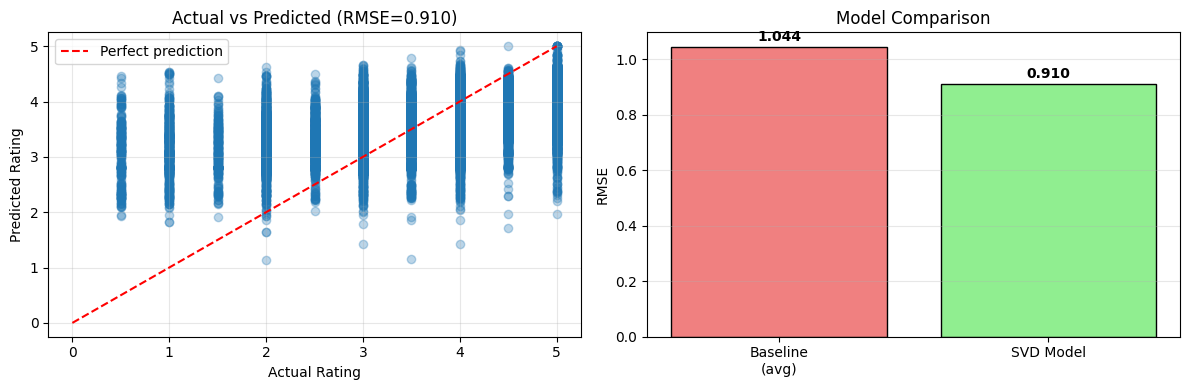


EVALUATION COMPLETE!


In [24]:
# Cell 11: Simple Model Performance Evaluation

print("=" * 60)
print("MODEL PERFORMANCE EVALUATION")
print("=" * 60)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for test set
test_predictions = []
test_actuals = []

for idx, row in test_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual_rating = row['rating']
    
    # Check if we can make a prediction
    if user_id in predictions.index and movie_id in predictions.columns:
        predicted_rating = predictions.loc[user_id, movie_id]
        test_predictions.append(predicted_rating)
        test_actuals.append(actual_rating)

# Convert to arrays
test_predictions = np.array(test_predictions)
test_actuals = np.array(test_actuals)

# ===== 1. MAIN METRICS =====
print("\n PREDICTION ACCURACY")
print("-" * 60)

rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
mae = mean_absolute_error(test_actuals, test_predictions)

print(f"Test samples: {len(test_predictions):,}")
print(f"RMSE: {rmse:.3f} (lower is better)")
print(f"MAE:  {mae:.3f} (lower is better)")

# ===== 2. HOW ACCURATE? =====
print("\n ACCURACY BREAKDOWN")
print("-" * 60)

errors = np.abs(test_predictions - test_actuals)
within_half = (errors <= 0.5).sum() / len(errors) * 100
within_one = (errors <= 1.0).sum() / len(errors) * 100

print(f"Predictions within ±0.5 stars: {within_half:.1f}%")
print(f"Predictions within ±1.0 stars: {within_one:.1f}%")

# ===== 3. COMPARE TO BASELINE =====
print("\n BASELINE COMPARISON")
print("-" * 60)

# Simple baseline: always predict the average rating
avg_rating = df_ratings['rating'].mean()
baseline_predictions = np.full(len(test_actuals), avg_rating)
baseline_rmse = np.sqrt(mean_squared_error(test_actuals, baseline_predictions))

print(f"Baseline (always predict {avg_rating:.1f}): RMSE = {baseline_rmse:.3f}")
print(f"Our SVD Model:                     RMSE = {rmse:.3f}")
improvement = (baseline_rmse - rmse) / baseline_rmse * 100
print(f"Improvement: {improvement:.1f}%")

# ===== 4. VERDICT =====
print("\n VERDICT")
print("-" * 60)
if rmse < 0.9:
    print("EXCELLENT - Model is highly accurate!")
elif rmse < 1.1:
    print("GOOD - Model performs well!")
elif rmse < 1.3:
    print("ACCEPTABLE - Model is okay, could be better")
else:
    print("NEEDS IMPROVEMENT - Try different parameters")

# ===== 5. SIMPLE VISUALIZATION =====
print("\n Creating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Actual vs Predicted
axes[0].scatter(test_actuals, test_predictions, alpha=0.3)
axes[0].plot([0, 5], [0, 5], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Actual vs Predicted (RMSE={rmse:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Model Comparison
models = ['Baseline\n(avg)', 'SVD Model']
rmse_values = [baseline_rmse, rmse]
colors = ['lightcoral', 'lightgreen']
axes[1].bar(models, rmse_values, color=colors, edgecolor='black')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(rmse_values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('svd_performance.png', dpi=150, bbox_inches='tight')
print("Saved: svd_performance.png")
plt.show()

print("\n" + "=" * 60)
print("EVALUATION COMPLETE!")
print("=" * 60)